# (숙제) Pytorch 모델 만들기 실습 

!pip install sklearn seaborn pandas numpy

# Prepare experiment

In [1]:
# for custom
epoch = 30
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# macro : It calculates metrics for each class individually and then takes unweighted mean of the measures.
# micro : It is calculated by considering the total TP, total FP and total FN of the model. It does not consider each class individually, It calculates the metrics globally. So for our example,

def get_metric(label_list, pred_list):
    print('acc/precision(macro|micro)/recall(macro|micro)/f1(macro|micro) : %.2f / %.2f|%.2f / %.2f|%.2f / %.2f|%.2f' % (
    accuracy_score(pred_list, label_list),
    precision_score(pred_list, label_list, average='macro'),
    precision_score(pred_list, label_list, average='micro'),
    recall_score(pred_list, label_list, average='macro'),
    recall_score(pred_list, label_list, average='micro'),
    f1_score(pred_list, label_list, average='macro'),
    f1_score(pred_list, label_list, average='micro')))
    print(classification_report(pred_list, label_list))

    print(confusion_matrix(pred_list, label_list))

    df_cm = pd.DataFrame(confusion_matrix(pred_list, label_list), index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])
    plt.figure(figsize = (17,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.show()    

In [2]:
# load library
import torch 
import torch.nn as nn #
import torch.nn.functional as F # various activation functions for model
import torchvision # You can load various Pretrained Model from this package 
import torchvision.datasets as vision_dsets
import torchvision.transforms as T # Transformation functions to manipulate images
import torch.optim as optim # various optimization functions for model
from torch.autograd import Variable 
from torch.utils import data
# random seed 고정
import random
import torch.backends.cudnn as cudnn
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

In [4]:
# download dataset
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2022-04-08 07:40:55--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2022-04-08 07:40:55--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [               <=>  ]  33.20M  9.96MB/s    in 3.8s    

2022-04-08 07:40:59 (8.84 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [5]:
def MNIST_DATA(root='./',train =True,transforms=None ,download =True,batch_size = 32,num_worker = 1):
    print ("[+] Get the MNIST DATA")
    """
    We will use Mnist data for our tutorial 
    """
    mnist_train = vision_dsets.MNIST(root = root,  #root is the place to store your data. 
                                    train = True,  
                                    transform = T.ToTensor(),
                                    download=False)
    mnist_test = vision_dsets.MNIST(root = root,
                                    train = False, 
                                    transform = T.ToTensor(),
                                    download=False)
    """
    Data Loader is a iterator that fetches the data with the number of desired batch size. 
    * Practical Guide : What is the optimal batch size? 
      - Usually.., higher the batter. 
      - We recommend to use it as a multiple of 2 to efficiently utilize the gpu memory. (related to bit size)
    """
    trainDataLoader = data.DataLoader(dataset = mnist_train,  # information about your data type
                                      batch_size = batch_size, # batch size
                                      shuffle =True, # Whether to shuffle your data for every epoch. (Very important for training performance)
                                      num_workers = 1) # number of workers to load your data. (usually number of cpu cores)

    testDataLoader = data.DataLoader(dataset = mnist_test, 
                                    batch_size = batch_size,
                                    shuffle = False, # we don't actually need to shuffle data for test
                                    num_workers = 1) #
    print ("[+] Finished loading data & Preprocessing")
    print('train/test batches : (%d) %d / %d'%(batch_size, len(trainDataLoader), len(testDataLoader)))
    return mnist_train, mnist_test, trainDataLoader, testDataLoader

In [6]:
trainDset, testDset, trainDataLoader, testDataLoader= MNIST_DATA(batch_size = 1024)  # Data Loader 

[+] Get the MNIST DATA
[+] Finished loading data & Preprocessing
train/test batches : (1024) 59 / 10


# Define Trainer

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

cuda


In [8]:
class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion, device='cuda'):
        """
        trainloader: train data's loader
        testloader: test data's loader
        net: model to train
        optimizer: optimizer to update your model
        criterion: loss function
        """
        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device  # for gpu
        
    def train(self, epochs=1):
        """
        epoch: number of times each training sample is used
        """
        self.net.train()
        for epoch in range(epochs):
            running_loss = 0.0  
            for i, data in enumerate(self.trainloader, 0): 
                # get the inputs
                inputs, labels = data # Return type for data in dataloader is tuple of (input_data, labels)
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                self.optimizer.zero_grad()    
                #  Question 1) what if we dind't clear up the gradients?
                # (answer) Pytorch calculate gradient by accumulating in the previous gradient. So we have to initialize the previous model parameter gradients to get the onlt current gradient.
                
                # forward + backward + optimize
                outputs = self.net(inputs) # get output after passing through the network
                loss = self.criterion(outputs, labels) # compute model's score using the loss function 
                loss.backward() # perform back-propagation from the loss
                self.optimizer.step() # perform gradient descent with given optimizer

            # print statistics
            running_loss += loss.item()
            print('%d : loss: %.3f' % (epoch, running_loss / (i+1)))
            running_loss = 0.0

        print('Finished Training')
        
    def test(self):
        self.net.eval()
        # Question 2) Why should we change the network into eval-mode?
        # (answewr) When the models using dropout or batch narmalization, we must specify whether model.eval() or model.train() because the structure is different when training and evaluating.
    
    
        test_loss = 0
        correct = 0
        
        label_list, pred_list = [], []
        for inputs, labels in self.testloader:
            inputs = inputs.to(device)
            labels = labels.to(device) 
            output = self.net(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            correct += pred.eq(labels.view_as(pred)).sum().item()
            
            label_list.extend(list(labels.detach().cpu().numpy()))
            pred_list.extend([tmp.numpy()[0] for tmp in list(pred.cpu())])
            
            test_loss /= len(self.testloader.dataset)
        print('\nTest set:  Accuracy: {}/{} ({:.3f}%)\n'.
                format(correct, len(self.testloader.dataset),
                100.* correct / len(self.testloader.dataset)))
        
        get_metric(label_list, pred_list)
        

# Exp (1) : 2-Layer Network + Sigmoid (23860) : ??%

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

model parameters : 23860
0 : loss: 0.039
1 : loss: 0.039
2 : loss: 0.039
3 : loss: 0.039
4 : loss: 0.039
5 : loss: 0.039
6 : loss: 0.039
7 : loss: 0.039
8 : loss: 0.039
9 : loss: 0.039
10 : loss: 0.039
11 : loss: 0.039
12 : loss: 0.039
13 : loss: 0.039
14 : loss: 0.039
15 : loss: 0.039
16 : loss: 0.039
17 : loss: 0.039
18 : loss: 0.039
19 : loss: 0.039
20 : loss: 0.039
21 : loss: 0.039
22 : loss: 0.039
23 : loss: 0.039
24 : loss: 0.039
25 : loss: 0.038
26 : loss: 0.038
27 : loss: 0.038
28 : loss: 0.038
29 : loss: 0.038
Finished Training

Test set:  Accuracy: 2287/10000 (22.870%)

acc/precision(macro|micro)/recall(macro|micro)/f1(macro|micro) : 0.23 / 0.22|0.23 / 0.29|0.23 / 0.17|0.23
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       968
           1       1.00      0.14      0.25      8096
           2       0.16      0.37      0.22       434
           3       0.01      0.32      0.02        25
           4       0.00      0.00   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: 

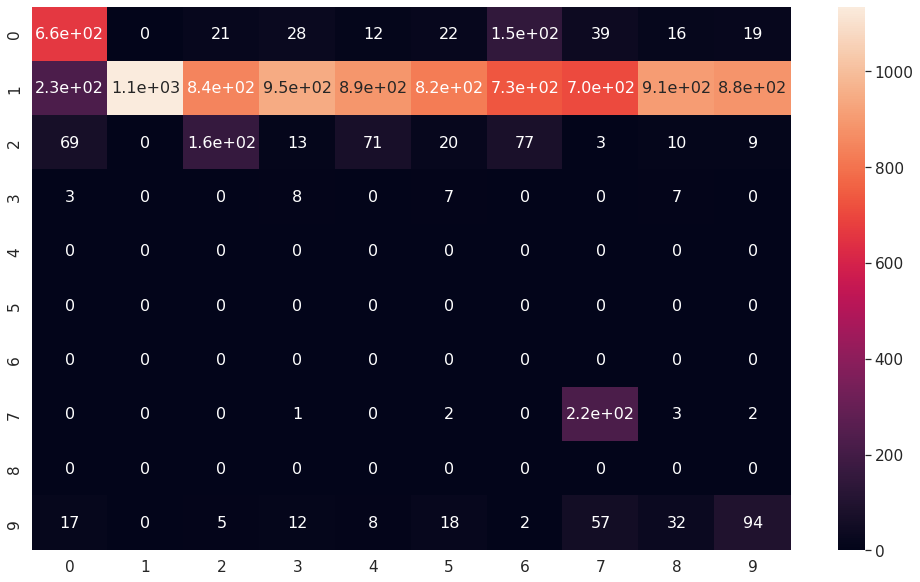

In [9]:
#2-Layer Network + Sigmoid : 22.87%(23860)
class MNIST_Net(nn.Module): 
    def __init__(self):
        super(MNIST_Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28, 30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1, 28*28) # x.view convert the shape of tensor, (Batch_size,28,28) --> (Batch_size,28*28)
        x = self.fc0(x) # 28*28 -> 30 
        x = torch.sigmoid(x) # Activation function 
        x = self.fc1(x)  # 30 -> 10, logit for each class
        return x

mnist_net = MNIST_Net().to(device) # create the neural network instance and load to the cuda memory.
print('model parameters : %d'%count_parameters(mnist_net))
criterion = nn.CrossEntropyLoss() # Define Loss Function. We use Cross-Entropy loss.
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) # optimizer receives training parameters and learning rate.

trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

trainer.train(epochs = epoch)

trainer.test()

# Exp (2) : 2-Layer Network + ReLU (23860): ??%

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

model parameters : 23860
0 : loss: 0.039
1 : loss: 0.039
2 : loss: 0.039
3 : loss: 0.039
4 : loss: 0.038
5 : loss: 0.038
6 : loss: 0.038
7 : loss: 0.038
8 : loss: 0.038
9 : loss: 0.038
10 : loss: 0.037
11 : loss: 0.037
12 : loss: 0.037
13 : loss: 0.037
14 : loss: 0.037
15 : loss: 0.037
16 : loss: 0.037
17 : loss: 0.036
18 : loss: 0.036
19 : loss: 0.036
20 : loss: 0.036
21 : loss: 0.035
22 : loss: 0.035
23 : loss: 0.035
24 : loss: 0.035
25 : loss: 0.035
26 : loss: 0.034
27 : loss: 0.034
28 : loss: 0.034
29 : loss: 0.034
Finished Training

Test set:  Accuracy: 4999/10000 (49.990%)

acc/precision(macro|micro)/recall(macro|micro)/f1(macro|micro) : 0.50 / 0.49|0.50 / 0.72|0.50 / 0.43|0.50
              precision    recall  f1-score   support

           0       0.99      0.33      0.50      2910
           1       0.93      0.72      0.81      1462
           2       0.15      0.99      0.26       156
           3       0.40      0.82      0.54       495
           4       0.01      1.00   

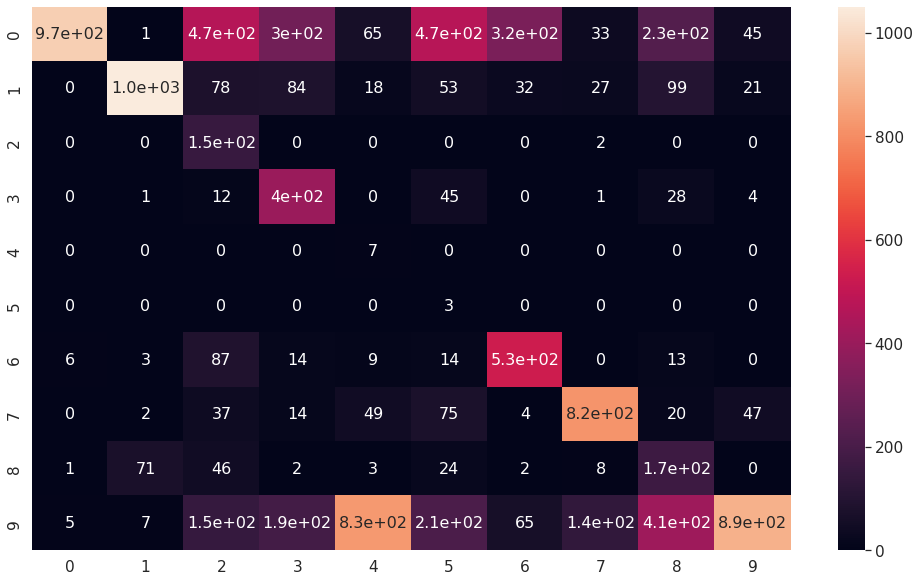

In [10]:
# 2-Layer Network + ReLU : 49.99%(23860)
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28, 30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.relu(x) # Activation function
        x = self.fc1(x)  # 30 -> 10
        return x
    
mnist_net = MNIST_Net().to(device)
print('model parameters : %d'%count_parameters(mnist_net))
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)

trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

trainer.train(epochs = epoch)

trainer.test()

# Exp (3) 3-Layer Network + Sigmoid(41090) : ??%

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

model parameters : 41090


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 : loss: 0.040
1 : loss: 0.040
2 : loss: 0.039
3 : loss: 0.040
4 : loss: 0.040
5 : loss: 0.040
6 : loss: 0.040
7 : loss: 0.039
8 : loss: 0.039
9 : loss: 0.039
10 : loss: 0.039
11 : loss: 0.039
12 : loss: 0.039
13 : loss: 0.039
14 : loss: 0.039
15 : loss: 0.039
16 : loss: 0.039
17 : loss: 0.039
18 : loss: 0.039
19 : loss: 0.039
20 : loss: 0.039
21 : loss: 0.039
22 : loss: 0.039
23 : loss: 0.039
24 : loss: 0.039
25 : loss: 0.039
26 : loss: 0.039
27 : loss: 0.039
28 : loss: 0.039
29 : loss: 0.039
Finished Training

Test set:  Accuracy: 1135/10000 (11.350%)

acc/precision(macro|micro)/recall(macro|micro)/f1(macro|micro) : 0.11 / 0.10|0.11 / 0.01|0.11 / 0.02|0.11
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.11      0.20     10000
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: 

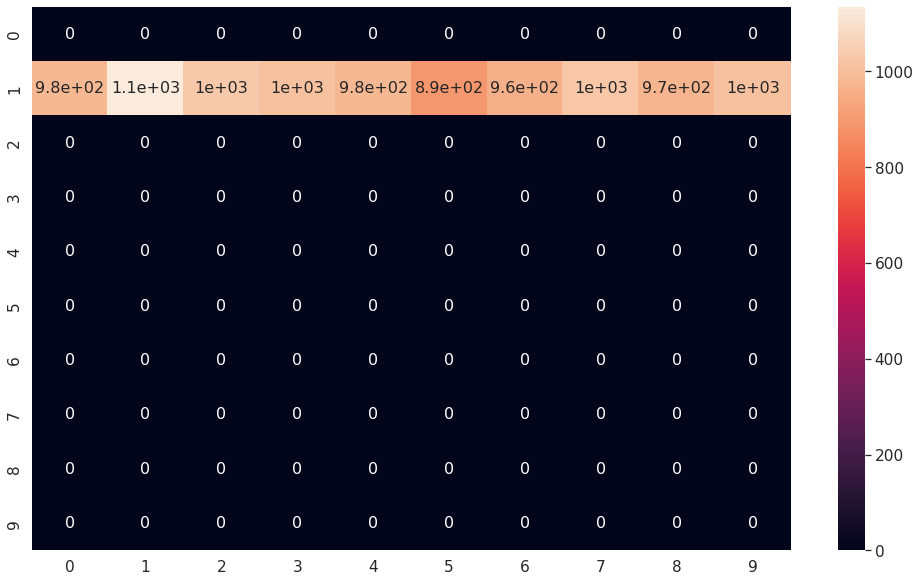

In [11]:
# 3-Layer Network + Sigmoid : 11.35%(41090)
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.sigmoid(x)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNIST_Net().to(device)
print('model parameters : %d'%count_parameters(mnist_net))
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)  

trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

trainer.train(epochs = epoch)

trainer.test()

# Exp (4) 3-Layer Network + ReLU(41090) : ??%

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

model parameters : 41090
0 : loss: 0.039
1 : loss: 0.039
2 : loss: 0.039
3 : loss: 0.039
4 : loss: 0.039
5 : loss: 0.039
6 : loss: 0.039
7 : loss: 0.039
8 : loss: 0.039
9 : loss: 0.039
10 : loss: 0.039
11 : loss: 0.039
12 : loss: 0.039
13 : loss: 0.039
14 : loss: 0.039
15 : loss: 0.039
16 : loss: 0.039
17 : loss: 0.039
18 : loss: 0.039
19 : loss: 0.039
20 : loss: 0.038
21 : loss: 0.038
22 : loss: 0.038
23 : loss: 0.038
24 : loss: 0.038
25 : loss: 0.038
26 : loss: 0.038
27 : loss: 0.038
28 : loss: 0.038
29 : loss: 0.038
Finished Training

Test set:  Accuracy: 1048/10000 (10.480%)

acc/precision(macro|micro)/recall(macro|micro)/f1(macro|micro) : 0.10 / 0.10|0.10 / 0.21|0.10 / 0.02|0.10
              precision    recall  f1-score   support

           0       0.02      1.00      0.03        17
           1       0.00      0.00      0.00         0
           2       0.00      1.00      0.01         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: 

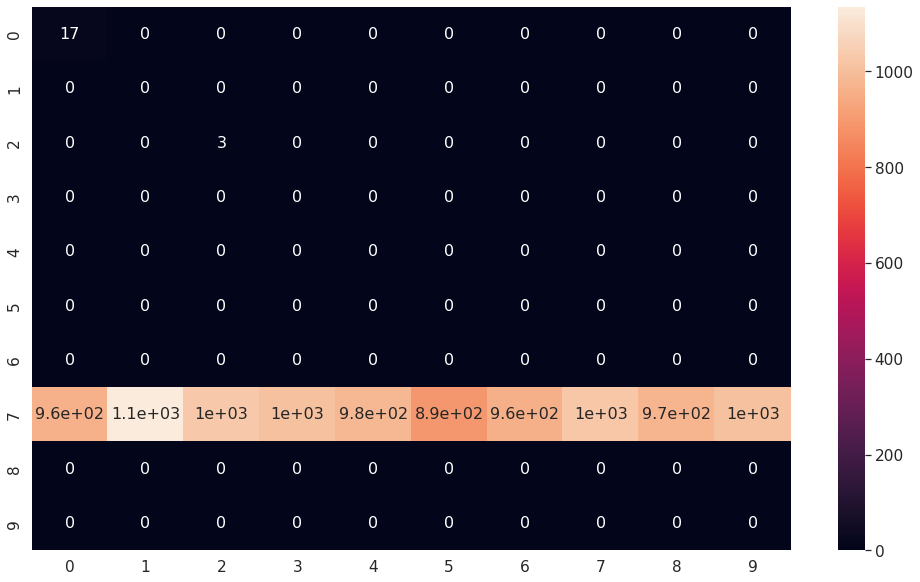

In [12]:
# 3-Layer Network + ReLU : 10.48%(41090)
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNIST_Net().to(device)
print('model parameters : %d'%count_parameters(mnist_net))
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) 

trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

trainer.train(epochs = epoch)

trainer.test()

## Let's change our Optimzer

# Exp (5) 3-Layer Network + ReLU + Adam(41090): ??%

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- Optimizer: Adam
- Loss: Cross-Entropy

model parameters : 41090
0 : loss: 0.011
1 : loss: 0.007
2 : loss: 0.005
3 : loss: 0.004
4 : loss: 0.004
5 : loss: 0.004
6 : loss: 0.004
7 : loss: 0.004
8 : loss: 0.003
9 : loss: 0.003
10 : loss: 0.003
11 : loss: 0.002
12 : loss: 0.002
13 : loss: 0.003
14 : loss: 0.002
15 : loss: 0.002
16 : loss: 0.002
17 : loss: 0.002
18 : loss: 0.002
19 : loss: 0.001
20 : loss: 0.002
21 : loss: 0.001
22 : loss: 0.002
23 : loss: 0.001
24 : loss: 0.001
25 : loss: 0.001
26 : loss: 0.001
27 : loss: 0.001
28 : loss: 0.001
29 : loss: 0.001
Finished Training

Test set:  Accuracy: 9697/10000 (96.970%)

acc/precision(macro|micro)/recall(macro|micro)/f1(macro|micro) : 0.97 / 0.97|0.97 / 0.97|0.97 / 0.97|0.97
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1002
           1       0.99      0.99      0.99      1138
           2       0.97      0.97      0.97      1036
           3       0.96      0.98      0.97       995
           4       0.97      0.98   

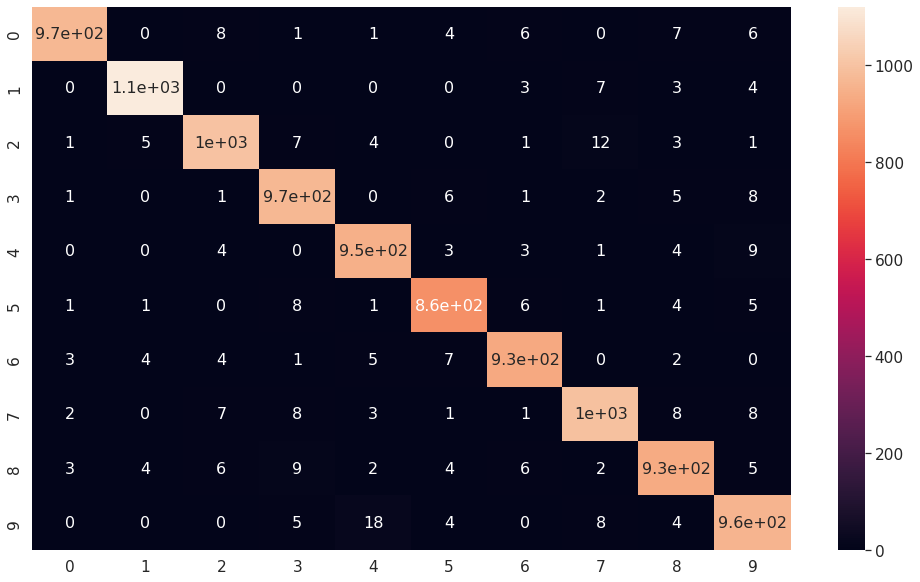

In [13]:
# 3-Layer Network + ReLU + Adam : 96.97%(41090)
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28, 50)  # Layer 1
        self.fc1 = nn.Linear(50, 30)  # Layer 2
        self.fc2 = nn.Linear(30, 10)  # Layer 3

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


mnist_net = MNIST_Net().to(device)
print('model parameters : %d' % count_parameters(mnist_net))
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

trainer = Trainer(trainloader=trainDataLoader,
                  testloader=testDataLoader,
                  net=mnist_net,
                  criterion=criterion,
                  optimizer=optimizer)

trainer.train(epochs=epoch)

trainer.test()

## Let's apply Batch Normalization

# Exp (6) 3-Layer Network + ReLU + Adam + Batch-Norm(41250): ??%

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

model parameters : 41250
0 : loss: 0.014
1 : loss: 0.007
2 : loss: 0.005
3 : loss: 0.003
4 : loss: 0.003
5 : loss: 0.002
6 : loss: 0.001
7 : loss: 0.002
8 : loss: 0.001
9 : loss: 0.001
10 : loss: 0.001
11 : loss: 0.002
12 : loss: 0.001
13 : loss: 0.001
14 : loss: 0.001
15 : loss: 0.001
16 : loss: 0.001
17 : loss: 0.001
18 : loss: 0.000
19 : loss: 0.000
20 : loss: 0.001
21 : loss: 0.000
22 : loss: 0.000
23 : loss: 0.000
24 : loss: 0.000
25 : loss: 0.000
26 : loss: 0.000
27 : loss: 0.000
28 : loss: 0.000
29 : loss: 0.000
Finished Training

Test set:  Accuracy: 9729/10000 (97.290%)

acc/precision(macro|micro)/recall(macro|micro)/f1(macro|micro) : 0.97 / 0.97|0.97 / 0.97|0.97 / 0.97|0.97
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       990
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1020
           3       0.97      0.96      0.97      1020
           4       0.97      0.97   

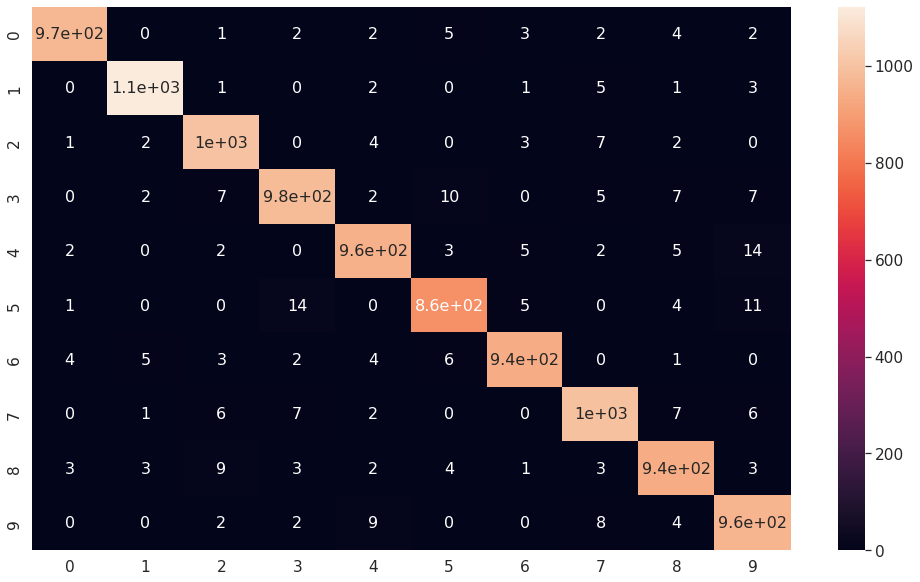

In [14]:
# 3-Layer Network + ReLU + Adam + Batch-Norm : 97.29%(41250)
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28, 50)  # Layer 1
        self.bn0 = nn.BatchNorm1d(50)  # BatchNorm 1
        self.fc1 = nn.Linear(50, 30)  # Layer 2
        self.bn1 = nn.BatchNorm1d(30)  # BatchNorm 2
        self.fc2 = nn.Linear(30, 10)  # Layer 3

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc0(x)
        x = self.bn0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


mnist_net = MNIST_Net().to(device)
print('model parameters : %d' % count_parameters(mnist_net))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

trainer = Trainer(trainloader=trainDataLoader,
                  testloader=testDataLoader,
                  net=mnist_net,
                  criterion=criterion,
                  optimizer=optimizer)

trainer.train(epochs=epoch)

trainer.test()

## Let's use Convolution Layer

# Exp (7) 3-Layer Network (Conv+Fc) + ReLU + Adam + Batch-Norm(11842): ??%

- Input: (28 * 28)
- Conv: 8 (6 * 6) filter with stride=2 
- Hidden dimension: 8 * 12 * 12
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

model parameters : 11842
0 : loss: 0.007
1 : loss: 0.004
2 : loss: 0.004
3 : loss: 0.003
4 : loss: 0.002
5 : loss: 0.002
6 : loss: 0.001
7 : loss: 0.001
8 : loss: 0.001
9 : loss: 0.002
10 : loss: 0.001
11 : loss: 0.001
12 : loss: 0.001
13 : loss: 0.001
14 : loss: 0.001
15 : loss: 0.001
16 : loss: 0.001
17 : loss: 0.001
18 : loss: 0.001
19 : loss: 0.001
20 : loss: 0.001
21 : loss: 0.001
22 : loss: 0.001
23 : loss: 0.001
24 : loss: 0.000
25 : loss: 0.001
26 : loss: 0.001
27 : loss: 0.001
28 : loss: 0.000
29 : loss: 0.001
Finished Training

Test set:  Accuracy: 9837/10000 (98.370%)

acc/precision(macro|micro)/recall(macro|micro)/f1(macro|micro) : 0.98 / 0.98|0.98 / 0.98|0.98 / 0.98|0.98
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       986
           1       0.99      0.99      0.99      1141
           2       0.98      0.98      0.98      1030
           3       0.99      0.99      0.99      1011
           4       0.99      0.99   

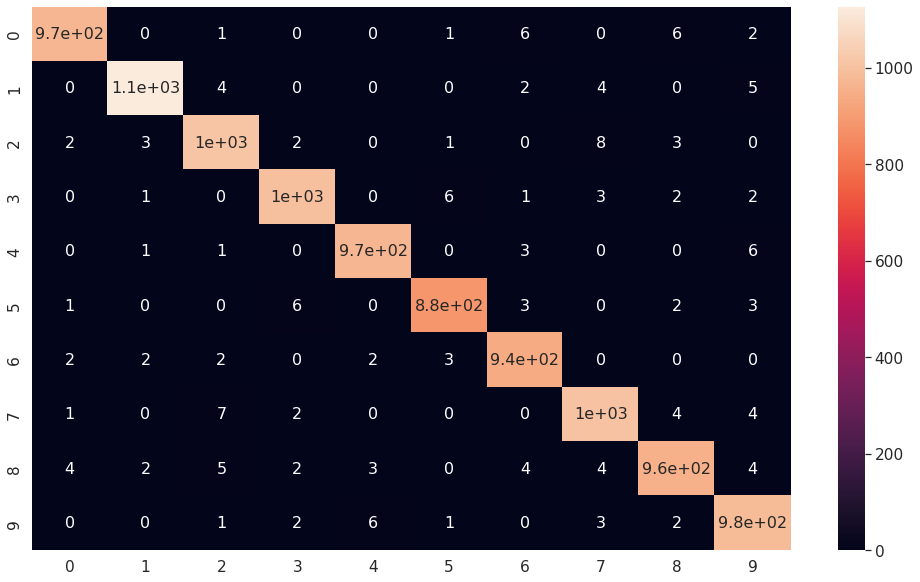

In [15]:
# 3-Layer Network (Conv+Fc) + ReLU + Adam + Batch-Norm : 98.37%(11842)
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=1,
                               out_channels=8,
                               kernel_size=6,
                               stride=2)  # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  # 2d batch-norm is used in 3d inputs
        self.fc = nn.Linear(8*12*12, 10)   # Layer 2

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x


mnist_net = MNIST_Net().to(device)
print('model parameters : %d' % count_parameters(mnist_net))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

trainer = Trainer(trainloader=trainDataLoader,
                  testloader=testDataLoader,
                  net=mnist_net,
                  criterion=criterion,
                  optimizer=optimizer)

trainer.train(epochs=epoch)

trainer.test()

## Pooling??

# Exp (8) 3-Layer Network (Conv+Pool+Fc) + ReLU + Adam + Batch-Norm(3202): ??%

- Input: (28 * 28)
- Conv: 8 (7 * 7) filter with stride=2 
- Pool: 2 * 2
- Hidden dimension: 8 * 6 * 6
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

model parameters : 3202
0 : loss: 0.011
1 : loss: 0.006
2 : loss: 0.005
3 : loss: 0.004
4 : loss: 0.003
5 : loss: 0.003
6 : loss: 0.002
7 : loss: 0.002
8 : loss: 0.002
9 : loss: 0.002
10 : loss: 0.002
11 : loss: 0.002
12 : loss: 0.001
13 : loss: 0.001
14 : loss: 0.001
15 : loss: 0.002
16 : loss: 0.001
17 : loss: 0.001
18 : loss: 0.001
19 : loss: 0.001
20 : loss: 0.001
21 : loss: 0.002
22 : loss: 0.001
23 : loss: 0.001
24 : loss: 0.001
25 : loss: 0.001
26 : loss: 0.001
27 : loss: 0.001
28 : loss: 0.001
29 : loss: 0.001
Finished Training

Test set:  Accuracy: 9795/10000 (97.950%)

acc/precision(macro|micro)/recall(macro|micro)/f1(macro|micro) : 0.98 / 0.98|0.98 / 0.98|0.98 / 0.98|0.98
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       988
           1       1.00      0.99      0.99      1146
           2       0.98      0.98      0.98      1032
           3       0.99      0.97      0.98      1029
           4       0.99      0.98    

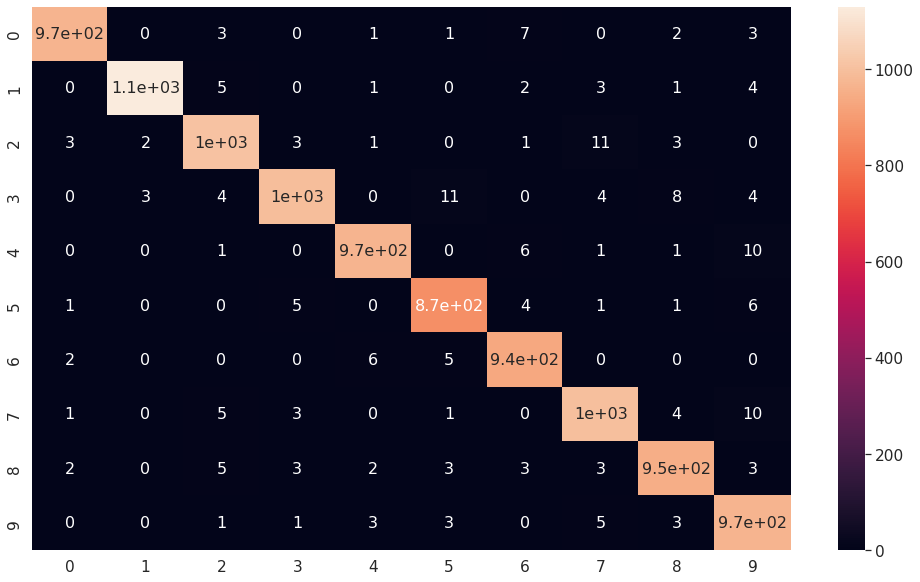

In [16]:
# 3-Layer Network (Conv+Pool+Fc) + ReLU + Adam + Batch-Norm : 97.95%(3202)
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  
        self.pool0 = nn.MaxPool2d(2)
        self.fc = nn.Linear(8*6*6, 10) 

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = self.pool0(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x
    
mnist_net = MNIST_Net().to(device)
print('model parameters : %d'%count_parameters(mnist_net))
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

trainer.train(epochs = epoch)

trainer.test()

In [ ]:
# Experiment Result 정리
- Exp (1) : 2-Layer Network + Sigmoid : ?
- Exp (2) : 2-Layer Network + ReLU : ?
- Exp (3) : 3-Layer Network + Sigmoid : ?
- Exp (4) : 3-Layer Network + ReLU : ?
- Exp (5) : 3-Layer Network + ReLU + Adam : ?
- Exp (6) : 3-Layer Network + ReLU + Adam + Batch-Norm : ?
- Exp (7) : 3-Layer Network (Conv+Fc) + ReLU + Adam + Batch-Norm : ?
- Exp (8) : 3-Layer Network (Conv+Pool+Fc) + ReLU + Adam + Batch-Norm : ?

# Experiment Result 정리
- Exp (1) : 2-Layer Network + Sigmoid (23860) : ??%
- Exp (2) : 2-Layer Network + ReLU (23860): ??%
- Exp (3) : 3-Layer Network + Sigmoid(41090) : ??%
- Exp (4) : 3-Layer Network + ReLU(41090) : ??%
- Exp (5) : 3-Layer Network + ReLU + Adam(41090): ??%
- Exp (6) : 3-Layer Network + ReLU + Adam + Batch-Norm(41250): ??%
- Exp (7) : 3-Layer Network (Conv+Fc) + ReLU + Adam + Batch-Norm(11842): ??%
- Exp (8) : 3-Layer Network (Conv+Pool+Fc) + ReLU + Adam + Batch-Norm(3202): ??%

## activiation function 차이에 따른 결과비교

- Exp (3) : 3-Layer Network + Sigmoid
- Exp (4) : 3-Layer Network + ReLU
- Exp(3) vs Exp(4) : ? vs ?

## Optimzer 차이에 따른 결과비교

- Exp (4) : 3-Layer Network + ReLU
- Exp (5) : 3-Layer Network + ReLU + Adam
- Exp(4) vs Exp(5) : ? vs ?

## Batch Normalization  차이에 따른 결과비교

- Exp (5) : 3-Layer Network + ReLU + Adam
- Exp (6) : 3-Layer Network + ReLU + Adam + Batch-Norm
- Exp(5) vs Exp(6) : ? vs ?

## Convolution Layer 차이에 따른 결과비교

- Exp (6) : 3-Layer Network + ReLU + Adam + Batch-Norm
- Exp (7) : 3-Layer Network (Conv+Fc) + ReLU + Adam + Batch-Norm
- Exp(6) vs Exp(7) : ? vs ?

## Pooling 차이에 따른 결과비교

- Exp (7) : 3-Layer Network (Conv+Fc) + ReLU + Adam + Batch-Norm
- Exp (8) : 3-Layer Network (Conv+Pool+Fc) + ReLU + Adam + Batch-Norm
- Exp(7) vs Exp(8) : ? vs ?